In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
import random
import os
from keras.applications import vgg16
from keras import Model
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D
from keras.models import model_from_json
import cv2

In [2]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode = "nearest",
    preprocessing_function = preprocess_input,
    validation_split=0.25
    )


In [3]:
train_generator = train_datagen.flow_from_directory(
    directory=r"dataset/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset='training'
)

Found 4372 images belonging to 3 classes.


In [5]:
train_generator[0]

(array([[[[-0.90588236, -0.90588236, -0.8901961 ],
          [-0.90588236, -0.90588236, -0.8901961 ],
          [-0.90588236, -0.90588236, -0.8901961 ],
          ...,
          [-0.7913437 , -0.67767036, -0.51789033],
          [-0.77468055, -0.67416835, -0.49659067],
          [-0.7727358 , -0.6786181 , -0.49038285]],
 
         [[-0.90588236, -0.90588236, -0.8901961 ],
          [-0.90588236, -0.90588236, -0.8901961 ],
          [-0.90588236, -0.90588236, -0.8901961 ],
          ...,
          [-0.78850883, -0.67412275, -0.5014703 ],
          [-0.777587  , -0.68346936, -0.49523407],
          [-0.7799052 , -0.68578756, -0.49755234]],
 
         [[-0.90588236, -0.90588236, -0.8901961 ],
          [-0.90588236, -0.90588236, -0.8901961 ],
          [-0.90588236, -0.90588236, -0.8901961 ],
          ...,
          [-0.7686964 , -0.6591555 , -0.47606128],
          [-0.76710033, -0.6725069 , -0.48443025],
          [-0.7603445 , -0.66622686, -0.47799158]],
 
         ...,
 
         [[-

In [6]:
valid_generator = train_datagen.flow_from_directory(
    directory=r"dataset/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 1456 images belonging to 3 classes.


In [7]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [8]:
base_model = MobileNetV2(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
x = base_model.output
x = AveragePooling2D(pool_size=(7,7))(x)
x = Flatten(name="flatten")(x)
x = Dense(128, activation='relu')(x)        
x = Dropout(0.5)(x) 
predictions = Dense(3, activation = 'softmax')(x)

In [9]:
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [11]:
#early stop 
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [12]:
#modelcheckpoint
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model.h5',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
136/136 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.8938
Epoch 00001: val_accuracy improved from -inf to 0.96875, saving model to best_model.h5
136/136 [==============================] - 291s 2s/step - loss: 0.2653 - accuracy: 0.8938 - val_loss: 0.0886 - val_accuracy: 0.9688
Epoch 2/20
136/136 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9539
Epoch 00002: val_accuracy improved from 0.96875 to 0.97639, saving model to best_model.h5
136/136 [==============================] - 309s 2s/step - loss: 0.1264 - accuracy: 0.9539 - val_loss: 0.0647 - val_accuracy: 0.9764
Epoch 3/20
136/136 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9599
Epoch 00003: val_accuracy did not improve from 0.97639
136/136 [==============================] - 272s 2s/step - loss: 0.1119 - accuracy: 0.9599 - val_loss: 0.0713 - val_accuracy: 0.9694
Epoch 4/

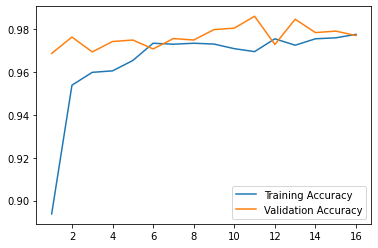

In [13]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20, #can change
                    callbacks=[es,mc])
score = model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_VALID)
print("Score", score)

epoch_list = list(range(1, len(hist.history['accuracy']) + 1)) 
plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.show()

In [ ]:
#load the saved model
from keras.models import load_model
saved_model=load_model('best_model.h5')
# evaluate only the saved model
_, train_acc = saved_model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_VALID)
_, test_acc = saved_model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_VALID)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

In [21]:
#save the model with maximum value accuracy
saved_model.save('facemask.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: facemask_eddy3.model/assets
